# Make sure the existance of all poster images

In [1]:
import pandas as pd
import os

# Check how many posters are missing
downloaded = set(int(f.split('.')[0]) for f in os.listdir('posters') if f.endswith('.jpg'))
all_movies = set(pd.read_csv('movies_train.csv')['movieId'])
missing_count = len(all_movies - downloaded)

print(f"Missing posters: {missing_count}")

Missing posters: 0


# Feature extraction

In [2]:
"""
Feature Extraction for Movie Posters
Extracts 8 different types of visual features from movie posters
"""

import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import mahotas
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
from skimage import img_as_ubyte

class PosterFeatureExtractor:
    """Extract multiple types of visual features from movie posters"""
    
    def __init__(self, posters_dir='posters', features_dir='features'):
        self.posters_dir = Path(posters_dir)
        self.features_dir = Path(features_dir)
        self.features_dir.mkdir(exist_ok=True)
        
    def extract_rgb_histogram(self, image, bins=32):
        """
        Extract RGB color histogram features
        Args:
            image: BGR image from cv2
            bins: number of bins per channel
        Returns:
            Flattened histogram feature vector
        """
        hist_features = []
        for i in range(3):  # For each channel (B, G, R)
            hist = cv2.calcHist([image], [i], None, [bins], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            hist_features.extend(hist)
        return np.array(hist_features)
    
    def extract_hsv_histogram(self, image, bins=32):
        """
        Extract HSV color histogram features
        Args:
            image: BGR image from cv2
            bins: number of bins per channel
        Returns:
            Flattened histogram feature vector
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist_features = []
        
        # H channel (0-180 in OpenCV)
        hist_h = cv2.calcHist([hsv], [0], None, [bins], [0, 180])
        hist_h = cv2.normalize(hist_h, hist_h).flatten()
        hist_features.extend(hist_h)
        
        # S and V channels (0-256)
        for i in [1, 2]:
            hist = cv2.calcHist([hsv], [i], None, [bins], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            hist_features.extend(hist)
            
        return np.array(hist_features)
    
    def extract_glcm_features(self, image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
        """
        Extract GLCM (Gray-Level Co-occurrence Matrix) texture features
        Args:
            image: BGR image from cv2
            distances: list of pixel pair distance offsets
            angles: list of pixel pair angles
        Returns:
            GLCM feature vector (contrast, dissimilarity, homogeneity, energy, correlation, ASM)
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize for faster computation
        gray = cv2.resize(gray, (256, 256))
        
        # Compute GLCM using mahotas
        features = mahotas.features.haralick(gray, return_mean=True)
        
        return features
    
    def extract_lbp_features(self, image, n_points=24, radius=3, bins=256):
        """
        Extract LBP (Local Binary Pattern) texture features
        Args:
            image: BGR image from cv2
            n_points: number of circularly symmetric neighbor points
            radius: radius of circle
            bins: number of histogram bins
        Returns:
            LBP histogram feature vector
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize for consistency
        gray = cv2.resize(gray, (256, 256))
        
        # Compute LBP
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # Compute histogram
        hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
        
        # Normalize
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        
        return hist
    
    def extract_hog_features(self, image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
        """
        Extract HOG (Histogram of Oriented Gradients) features
        Args:
            image: BGR image from cv2
            orientations: number of orientation bins
            pixels_per_cell: size of a cell
            cells_per_block: number of cells in each block
        Returns:
            HOG feature vector
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize to standard size
        gray = cv2.resize(gray, (256, 256))
        
        # Extract HOG features
        features = hog(gray, orientations=orientations, 
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      visualize=False, feature_vector=True)
        
        return features
    
    def extract_sift_features(self, image, n_features=100):
        """
        Extract SIFT (Scale-Invariant Feature Transform) features
        Uses bag-of-visual-words approach with fixed vocabulary size
        Args:
            image: BGR image from cv2
            n_features: number of features to extract
        Returns:
            Aggregated SIFT feature vector
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize for consistency
        gray = cv2.resize(gray, (256, 256))
        
        # Initialize SIFT detector
        sift = cv2.SIFT_create(nfeatures=n_features)
        
        # Detect and compute
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        
        if descriptors is None or len(descriptors) == 0:
            # Return zero vector if no features found
            return np.zeros(128)
        
        # Aggregate descriptors (mean pooling)
        features = np.mean(descriptors, axis=0)
        
        return features
    
    def extract_hu_moments(self, image):
        """
        Extract Hu Moments (shape features)
        Args:
            image: BGR image from cv2
        Returns:
            7 Hu moment invariants
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize for consistency
        gray = cv2.resize(gray, (256, 256))
        
        # Apply threshold to get binary image
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        
        # Calculate moments
        moments = cv2.moments(binary)
        
        # Calculate Hu Moments
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Apply log transform for better scale invariance
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        
        return hu_moments
    
    def extract_zernike_moments(self, image, radius=128, degree=8):
        """
        Extract Zernike Moments (shape features)
        Args:
            image: BGR image from cv2
            radius: radius for Zernike computation
            degree: maximum degree of Zernike polynomials
        Returns:
            Zernike moment feature vector
        """
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Resize to standard size
        gray = cv2.resize(gray, (256, 256))
        
        # Convert to uint8 if needed
        if gray.dtype != np.uint8:
            gray = img_as_ubyte(gray)
        
        # Compute Zernike moments using mahotas
        zernike = mahotas.features.zernike_moments(gray, radius=radius, degree=degree)
        
        return zernike
    
    def load_image(self, image_path):
        """Load and validate image"""
        try:
            image = cv2.imread(str(image_path))
            if image is None:
                return None
            return image
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            return None
    
    def extract_all_features(self, movie_ids=None):
        """
        Extract all 8 types of features for all posters
        Args:
            movie_ids: list of movie IDs to process (if None, process all)
        """
        # Get all poster files
        poster_files = sorted(list(self.posters_dir.glob('*.jpg')))
        
        if not poster_files:
            print(f"No poster files found in {self.posters_dir}")
            return
        
        print(f"Found {len(poster_files)} poster files")
        
        # Initialize dictionaries to store features
        features_dict = {
            'RGB': [],
            'HSV': [],
            'GLCM': [],
            'LBP': [],
            'HOG': [],
            'SIFT': [],
            'Hu': [],
            'Zernike': []
        }
        
        movieIds = []
        failed_images = []
        
        # Process each poster
        for poster_file in tqdm(poster_files, desc="Extracting features"):
            # Extract movieId from filename (e.g., "123.jpg" -> 123)
            try:
                movie_id = int(poster_file.stem)
            except ValueError:
                print(f"Skipping invalid filename: {poster_file.name}")
                continue
            
            # Skip if not in requested movie_ids
            if movie_ids is not None and movie_id not in movie_ids:
                continue
            
            # Load image
            image = self.load_image(poster_file)
            if image is None:
                failed_images.append(movie_id)
                continue
            
            try:
                # Extract all features
                rgb_feat = self.extract_rgb_histogram(image, bins=32)
                hsv_feat = self.extract_hsv_histogram(image, bins=32)
                glcm_feat = self.extract_glcm_features(image)
                lbp_feat = self.extract_lbp_features(image)
                hog_feat = self.extract_hog_features(image)
                sift_feat = self.extract_sift_features(image)
                hu_feat = self.extract_hu_moments(image)
                zernike_feat = self.extract_zernike_moments(image)
                
                # Store features
                movieIds.append(movie_id)
                features_dict['RGB'].append(rgb_feat)
                features_dict['HSV'].append(hsv_feat)
                features_dict['GLCM'].append(glcm_feat)
                features_dict['LBP'].append(lbp_feat)
                features_dict['HOG'].append(hog_feat)
                features_dict['SIFT'].append(sift_feat)
                features_dict['Hu'].append(hu_feat)
                features_dict['Zernike'].append(zernike_feat)
                
            except Exception as e:
                print(f"Error processing {poster_file.name}: {e}")
                failed_images.append(movie_id)
                continue
        
        # Save features to CSV files
        print("\nSaving features to CSV files...")
        for method_name, features_list in features_dict.items():
            if not features_list:
                print(f"No features extracted for {method_name}")
                continue
            
            # Convert to numpy array
            features_array = np.array(features_list)
            
            # Create DataFrame
            feature_cols = [f'{method_name}_feat_{i}' for i in range(features_array.shape[1])]
            df = pd.DataFrame(features_array, columns=feature_cols)
            df.insert(0, 'movieId', movieIds)
            
            # Save to CSV
            output_path = self.features_dir / f'feature_{method_name}.csv'
            df.to_csv(output_path, index=False)
            print(f"Saved {method_name} features: {features_array.shape} -> {output_path}")
        
        # Report results
        print(f"\n{'='*60}")
        print(f"Feature extraction completed!")
        print(f"Total processed: {len(movieIds)}")
        print(f"Failed images: {len(failed_images)}")
        if failed_images:
            print(f"Failed movieIds: {failed_images[:10]}{'...' if len(failed_images) > 10 else ''}")
        print(f"{'='*60}")


def main():
    """Main execution function"""
    print("Movie Poster Feature Extraction System")
    print("="*60)
    
    # Initialize extractor
    extractor = PosterFeatureExtractor(posters_dir='posters', features_dir='features')
    
    # Extract all features
    extractor.extract_all_features()
    
    print("\nAll features have been extracted and saved!")
    print("Check the 'features' folder for CSV files:")
    print("  - feature_RGB.csv")
    print("  - feature_HSV.csv")
    print("  - feature_GLCM.csv")
    print("  - feature_LBP.csv")
    print("  - feature_HOG.csv")
    print("  - feature_SIFT.csv")
    print("  - feature_Hu.csv")
    print("  - feature_Zernike.csv")


if __name__ == "__main__":
    main()

Movie Poster Feature Extraction System
Found 6819 poster files


Extracting features: 100%|██████████| 6819/6819 [32:48<00:00,  3.46it/s]



Saving features to CSV files...
Saved RGB features: (6819, 96) -> features\feature_RGB.csv
Saved HSV features: (6819, 96) -> features\feature_HSV.csv
Saved GLCM features: (6819, 13) -> features\feature_GLCM.csv
Saved LBP features: (6819, 256) -> features\feature_LBP.csv
Saved HOG features: (6819, 8100) -> features\feature_HOG.csv
Saved SIFT features: (6819, 128) -> features\feature_SIFT.csv
Saved Hu features: (6819, 7) -> features\feature_Hu.csv
Saved Zernike features: (6819, 25) -> features\feature_Zernike.csv

Feature extraction completed!
Total processed: 6819
Failed images: 0

All features have been extracted and saved!
Check the 'features' folder for CSV files:
  - feature_RGB.csv
  - feature_HSV.csv
  - feature_GLCM.csv
  - feature_LBP.csv
  - feature_HOG.csv
  - feature_SIFT.csv
  - feature_Hu.csv
  - feature_Zernike.csv


# Apply dimention reduction

In [1]:
# DIMENSIONALITY REDUCTION - FIXED VERSION
# Fixed t-SNE parameter issue (n_iter -> max_iter)

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ========================================
# UTILITY FUNCTIONS
# ========================================

def load_features(feature_path):
    """Load feature CSV file"""
    df = pd.read_csv(feature_path)
    movie_ids = df['movieId'].values
    features = df.drop('movieId', axis=1).values
    return movie_ids, features

def load_genres(train_csv_path='movies_train.csv'):
    """Load genre information and create primary genre labels"""
    df = pd.read_csv(train_csv_path)
    genre_dict = {}
    for _, row in df.iterrows():
        movie_id = row['movieId']
        genres = row['genres']
        if pd.isna(genres) or genres == '(no genres listed)':
            primary_genre = 'Unknown'
        else:
            primary_genre = genres.split('|')[0]
        genre_dict[movie_id] = primary_genre
    return genre_dict

def normalize_features(features):
    """Normalize features using StandardScaler"""
    scaler = StandardScaler()
    normalized = scaler.fit_transform(features)
    return normalized, scaler

def save_reduced_features(movie_ids, reduced_features, output_path, prefix):
    """Save reduced features to CSV"""
    n_components = reduced_features.shape[1]
    df = pd.DataFrame(reduced_features, columns=[f'comp_{i}' for i in range(n_components)])
    df.insert(0, 'movieId', movie_ids)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path, index=False)
    print(f"  ✓ Saved: {output_path.name} ({reduced_features.shape[1]} components)")

# ========================================
# DIMENSIONALITY REDUCTION METHODS
# ========================================

class PCA_FromScratch:
    """PCA Implementation from Scratch"""
    
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
    
    def fit(self, X):
        """Fit PCA on data X"""
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        n_samples = X.shape[0]
        cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        self.components_ = eigenvectors[:, :self.n_components].T
        self.explained_variance_ = eigenvalues[:self.n_components]
        self.explained_variance_ratio_ = self.explained_variance_ / np.sum(eigenvalues)
        return self
    
    def transform(self, X):
        """Transform data using fitted PCA"""
        X_centered = X - self.mean_
        return np.dot(X_centered, self.components_.T)
    
    def fit_transform(self, X):
        """Fit and transform in one step"""
        self.fit(X)
        return self.transform(X)


class LDA_FromScratch:
    """LDA Implementation from Scratch"""
    
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None
    
    def fit(self, X, y):
        """Fit LDA on data X with labels y"""
        n_features = X.shape[1]
        class_labels = np.unique(y)
        n_classes = len(class_labels)
        
        if self.n_components is None:
            self.n_components = min(n_features, n_classes - 1)
        else:
            self.n_components = min(self.n_components, n_classes - 1)
        
        self.mean_ = np.mean(X, axis=0)
        S_W = np.zeros((n_features, n_features))
        S_B = np.zeros((n_features, n_features))
        
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            n_c = X_c.shape[0]
            S_W += np.dot((X_c - mean_c).T, (X_c - mean_c))
            mean_diff = (mean_c - self.mean_).reshape(-1, 1)
            S_B += n_c * np.dot(mean_diff, mean_diff.T)
        
        try:
            S_W_reg = S_W + np.eye(n_features) * 1e-6
            eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(S_W_reg), S_B))
            idx = np.argsort(np.abs(eigenvalues))[::-1]
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[:, idx]
            self.components_ = np.real(eigenvectors[:, :self.n_components]).T
        except np.linalg.LinAlgError:
            print("  ⚠ Warning: LDA encountered numerical issues, using fallback")
            pca = PCA_FromScratch(n_components=self.n_components)
            pca.fit(X)
            self.components_ = pca.components_
        
        return self
    
    def transform(self, X):
        """Transform data using fitted LDA"""
        return np.dot(X, self.components_.T)
    
    def fit_transform(self, X, y):
        """Fit and transform in one step"""
        self.fit(X, y)
        return self.transform(X)


class SVD_FromScratch:
    """SVD-based dimensionality reduction from Scratch"""
    
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None
        self.singular_values_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
    
    def fit(self, X):
        """Fit SVD on data X"""
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)
        self.components_ = Vt[:self.n_components]
        self.singular_values_ = s[:self.n_components]
        n_samples = X.shape[0]
        self.explained_variance_ = (s ** 2) / (n_samples - 1)
        self.explained_variance_ = self.explained_variance_[:self.n_components]
        total_var = np.sum((s ** 2) / (n_samples - 1))
        self.explained_variance_ratio_ = self.explained_variance_ / total_var
        return self
    
    def transform(self, X):
        """Transform data using fitted SVD"""
        X_centered = X - self.mean_
        return np.dot(X_centered, self.components_.T)
    
    def fit_transform(self, X):
        """Fit and transform in one step"""
        self.fit(X)
        return self.transform(X)


def apply_tsne(X, n_components=2, random_state=42):
    """Apply t-SNE using sklearn - FIXED VERSION"""
    # Fixed: Changed n_iter to max_iter for newer sklearn versions
    tsne = TSNE(n_components=n_components, 
                random_state=random_state, 
                perplexity=30, 
                max_iter=1000,  # FIXED: was n_iter
                verbose=0)
    return tsne.fit_transform(X)


def apply_umap(X, n_components=2, random_state=42):
    """Apply UMAP using umap-learn"""
    reducer = umap.UMAP(n_components=n_components, 
                        random_state=random_state,
                        n_neighbors=15, 
                        min_dist=0.1)
    return reducer.fit_transform(X)


# ========================================
# MAIN REDUCTION PIPELINE
# ========================================

def reduce_single_feature(feature_name, features_dir='features', 
                         output_dir='reduced_dim/single_features',
                         train_csv='movies_train.csv'):
    """Apply all 5 dimensionality reduction methods to a single feature type"""
    
    print(f"\n{'='*70}")
    print(f"Processing {feature_name} Features")
    print(f"{'='*70}")
    
    # Load features
    feature_path = Path(features_dir) / f'feature_{feature_name}.csv'
    if not feature_path.exists():
        print(f"  ✗ Error: {feature_path} not found!")
        return
    
    movie_ids, features = load_features(feature_path)
    print(f"  ✓ Loaded features: {features.shape}")
    
    # Normalize features
    features_normalized, scaler = normalize_features(features)
    print(f"  ✓ Normalized features")
    
    # Load genres for LDA
    genre_dict = load_genres(train_csv)
    labels = np.array([genre_dict.get(mid, 'Unknown') for mid in movie_ids])
    print(f"  ✓ Loaded genres: {len(np.unique(labels))} unique genres")
    
    # Create output directory
    output_base = Path(output_dir) / feature_name
    output_base.mkdir(parents=True, exist_ok=True)
    
    # ========================================
    # 1. PCA
    # ========================================
    print(f"\n  🔵 Applying PCA...")
    for n_comp in [50, 100]:
        if n_comp <= features.shape[1]:
            pca = PCA_FromScratch(n_components=n_comp)
            reduced = pca.fit_transform(features_normalized)
            output_path = output_base / f'{feature_name}_pca_{n_comp}d.csv'
            save_reduced_features(movie_ids, reduced, output_path, 'PCA')
            var_explained = np.sum(pca.explained_variance_ratio_) * 100
            print(f"    Variance explained: {var_explained:.2f}%")
    
    # ========================================
    # 2. LDA
    # ========================================
    print(f"\n  🟢 Applying LDA...")
    n_classes = len(np.unique(labels))
    n_comp_lda = min(n_classes - 1, features.shape[1])
    lda = LDA_FromScratch(n_components=n_comp_lda)
    reduced = lda.fit_transform(features_normalized, labels)
    output_path = output_base / f'{feature_name}_lda_{n_comp_lda}d.csv'
    save_reduced_features(movie_ids, reduced, output_path, 'LDA')
    
    # ========================================
    # 3. SVD
    # ========================================
    print(f"\n  🟣 Applying SVD...")
    for n_comp in [50, 100]:
        if n_comp <= features.shape[1]:
            svd = SVD_FromScratch(n_components=n_comp)
            reduced = svd.fit_transform(features_normalized)
            output_path = output_base / f'{feature_name}_svd_{n_comp}d.csv'
            save_reduced_features(movie_ids, reduced, output_path, 'SVD')
            var_explained = np.sum(svd.explained_variance_ratio_) * 100
            print(f"    Variance explained: {var_explained:.2f}%")
    
    # ========================================
    # 4. t-SNE
    # ========================================
    print(f"\n  🔴 Applying t-SNE...")
    for n_comp in [2, 3]:
        reduced = apply_tsne(features_normalized, n_components=n_comp)
        output_path = output_base / f'{feature_name}_tsne_{n_comp}d.csv'
        save_reduced_features(movie_ids, reduced, output_path, 't-SNE')
    
    # ========================================
    # 5. UMAP
    # ========================================
    print(f"\n  🟡 Applying UMAP...")
    for n_comp in [2, 3]:
        reduced = apply_umap(features_normalized, n_components=n_comp)
        output_path = output_base / f'{feature_name}_umap_{n_comp}d.csv'
        save_reduced_features(movie_ids, reduced, output_path, 'UMAP')
    
    print(f"\n  ✅ Completed {feature_name}")


def reduce_all_features(features_dir='features', 
                       output_dir='reduced_dim/single_features',
                       train_csv='movies_train.csv'):
    """Apply all dimensionality reduction methods to all feature types"""
    
    print("="*70)
    print("DIMENSIONALITY REDUCTION PIPELINE - FIXED VERSION")
    print("="*70)
    print(f"Input: {features_dir}/")
    print(f"Output: {output_dir}/")
    print(f"Methods: PCA, LDA, SVD, t-SNE, UMAP")
    print("="*70)
    
    feature_types = ['RGB', 'HSV', 'GLCM', 'LBP', 'HOG', 'SIFT', 'Hu', 'Zernike']
    
    for feature_name in feature_types:
        try:
            reduce_single_feature(feature_name, features_dir, output_dir, train_csv)
        except Exception as e:
            print(f"\n  ✗ Error processing {feature_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print("\n" + "="*70)
    print("✅ ALL FEATURES PROCESSED!")
    print("="*70)
    
    # Summary
    output_path = Path(output_dir)
    total_files = len(list(output_path.rglob('*.csv')))
    print(f"\nTotal reduced feature files created: {total_files}")
    print(f"Location: {output_dir}/")
    
    print("\n📊 Summary by Feature:")
    for feature_name in feature_types:
        feature_dir = output_path / feature_name
        if feature_dir.exists():
            n_files = len(list(feature_dir.glob('*.csv')))
            print(f"  {feature_name:10s}: {n_files} files")


# ========================================
# RUN THE PIPELINE
# ========================================

if __name__ == "__main__":
    reduce_all_features(
        features_dir='features',
        output_dir='reduced_dim/single_features',
        train_csv='movies_train.csv'
    )

DIMENSIONALITY REDUCTION PIPELINE - FIXED VERSION
Input: features/
Output: reduced_dim/single_features/
Methods: PCA, LDA, SVD, t-SNE, UMAP

Processing RGB Features
  ✓ Loaded features: (6819, 96)
  ✓ Normalized features
  ✓ Loaded genres: 19 unique genres

  🔵 Applying PCA...
  ✓ Saved: RGB_pca_50d.csv (50 components)
    Variance explained: 91.78%

  🟢 Applying LDA...
  ✓ Saved: RGB_lda_18d.csv (18 components)

  🟣 Applying SVD...
  ✓ Saved: RGB_svd_50d.csv (50 components)
    Variance explained: 91.78%

  🔴 Applying t-SNE...
  ✓ Saved: RGB_tsne_2d.csv (2 components)
  ✓ Saved: RGB_tsne_3d.csv (3 components)

  🟡 Applying UMAP...
  ✓ Saved: RGB_umap_2d.csv (2 components)
  ✓ Saved: RGB_umap_3d.csv (3 components)

  ✅ Completed RGB

Processing HSV Features
  ✓ Loaded features: (6819, 96)
  ✓ Normalized features
  ✓ Loaded genres: 19 unique genres

  🔵 Applying PCA...
  ✓ Saved: HSV_pca_50d.csv (50 components)
    Variance explained: 89.29%

  🟢 Applying LDA...
  ✓ Saved: HSV_lda_18d.c

In [2]:
# DIMENSIONALITY REDUCTION - COMBINED FEATURES
# Combines multiple feature types and applies all 5 reduction methods

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
import warnings
warnings.filterwarnings('ignore')

# ========================================
# COPY THE SAME CLASSES FROM SINGLE FEATURES
# ========================================

class PCA_FromScratch:
    """PCA Implementation from Scratch"""
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.components_ = None
        self.mean_ = None
        self.explained_variance_ratio_ = None
    
    def fit_transform(self, X):
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        n_samples = X.shape[0]
        cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        self.components_ = eigenvectors[:, :self.n_components].T
        self.explained_variance_ratio_ = eigenvalues[:self.n_components] / np.sum(eigenvalues)
        return np.dot(X_centered, self.components_.T)


class LDA_FromScratch:
    """LDA Implementation from Scratch"""
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components_ = None
    
    def fit_transform(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)
        n_classes = len(class_labels)
        
        if self.n_components is None:
            self.n_components = min(n_features, n_classes - 1)
        else:
            self.n_components = min(self.n_components, n_classes - 1)
        
        mean_overall = np.mean(X, axis=0)
        S_W = np.zeros((n_features, n_features))
        S_B = np.zeros((n_features, n_features))
        
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            S_W += np.dot((X_c - mean_c).T, (X_c - mean_c))
            mean_diff = (mean_c - mean_overall).reshape(-1, 1)
            S_B += X_c.shape[0] * np.dot(mean_diff, mean_diff.T)
        
        try:
            S_W_reg = S_W + np.eye(n_features) * 1e-6
            eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(S_W_reg), S_B))
            idx = np.argsort(np.abs(eigenvalues))[::-1]
            eigenvectors = eigenvectors[:, idx]
            self.components_ = np.real(eigenvectors[:, :self.n_components]).T
        except:
            pca = PCA_FromScratch(n_components=self.n_components)
            self.components_ = pca.fit_transform(X).T[:self.n_components]
        
        return np.dot(X, self.components_.T)


class SVD_FromScratch:
    """SVD-based dimensionality reduction"""
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.components_ = None
        self.explained_variance_ratio_ = None
    
    def fit_transform(self, X):
        mean = np.mean(X, axis=0)
        X_centered = X - mean
        U, s, Vt = np.linalg.svd(X_centered, full_matrices=False)
        self.components_ = Vt[:self.n_components]
        n_samples = X.shape[0]
        explained_variance = (s ** 2) / (n_samples - 1)
        total_var = np.sum(explained_variance)
        self.explained_variance_ratio_ = explained_variance[:self.n_components] / total_var
        return np.dot(X_centered, self.components_.T)


def apply_tsne(X, n_components=2, random_state=42):
    """Apply t-SNE using sklearn"""
    tsne = TSNE(n_components=n_components, random_state=random_state, 
                perplexity=30, max_iter=1000, verbose=0)
    return tsne.fit_transform(X)


def apply_umap(X, n_components=2, random_state=42):
    """Apply UMAP using umap-learn"""
    reducer = umap.UMAP(n_components=n_components, random_state=random_state,
                        n_neighbors=15, min_dist=0.1)
    return reducer.fit_transform(X)


# ========================================
# UTILITY FUNCTIONS
# ========================================

def load_genres(train_csv_path='movies_train.csv'):
    """Load genre information"""
    df = pd.read_csv(train_csv_path)
    genre_dict = {}
    for _, row in df.iterrows():
        genres = row['genres']
        if pd.isna(genres) or genres == '(no genres listed)':
            primary = 'Unknown'
        else:
            primary = genres.split('|')[0]
        genre_dict[row['movieId']] = primary
    return genre_dict


def load_and_combine_features(feature_names, features_dir='features'):
    """
    Load and combine multiple feature types
    
    Args:
        feature_names: List of feature names (e.g., ['RGB', 'HSV', 'HOG'])
        features_dir: Directory containing feature CSV files
    
    Returns:
        movie_ids, combined_features
    """
    dfs = []
    
    for feature_name in feature_names:
        feature_path = Path(features_dir) / f'feature_{feature_name}.csv'
        if not feature_path.exists():
            print(f"  ⚠ Warning: {feature_path} not found, skipping")
            continue
        
        df = pd.read_csv(feature_path)
        dfs.append(df)
    
    if not dfs:
        raise ValueError("No valid feature files found!")
    
    # Merge all dataframes on movieId
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = combined_df.merge(df, on='movieId', how='inner')
    
    movie_ids = combined_df['movieId'].values
    features = combined_df.drop('movieId', axis=1).values
    
    return movie_ids, features


def normalize_features(features):
    """Normalize features using StandardScaler"""
    scaler = StandardScaler()
    normalized = scaler.fit_transform(features)
    return normalized, scaler


def save_reduced_features(movie_ids, reduced_features, output_path):
    """Save reduced features to CSV"""
    n_components = reduced_features.shape[1]
    df = pd.DataFrame(reduced_features, columns=[f'comp_{i}' for i in range(n_components)])
    df.insert(0, 'movieId', movie_ids)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path, index=False)
    print(f"  ✓ Saved: {output_path.name} ({reduced_features.shape[1]} components)")


# ========================================
# COMBINED FEATURES REDUCTION
# ========================================

def reduce_combined_features(feature_names, combination_name,
                            features_dir='features',
                            output_dir='reduced_dim/combined_features',
                            train_csv='movies_train.csv'):
    """
    Apply all 5 dimensionality reduction methods to combined features
    
    Args:
        feature_names: List of feature names to combine (e.g., ['RGB', 'HSV'])
        combination_name: Name for this combination (e.g., 'RGB_HSV')
        features_dir: Directory containing feature CSV files
        output_dir: Output directory for reduced features
        train_csv: Path to training CSV with genre information
    """
    
    print(f"\n{'='*70}")
    print(f"Processing Combined Features: {combination_name}")
    print(f"Features: {', '.join(feature_names)}")
    print(f"{'='*70}")
    
    # Load and combine features
    try:
        movie_ids, features = load_and_combine_features(feature_names, features_dir)
        print(f"  ✓ Combined features: {features.shape}")
    except Exception as e:
        print(f"  ✗ Error loading features: {e}")
        return
    
    # Normalize features
    features_normalized, scaler = normalize_features(features)
    print(f"  ✓ Normalized features")
    
    # Load genres for LDA
    genre_dict = load_genres(train_csv)
    labels = np.array([genre_dict.get(mid, 'Unknown') for mid in movie_ids])
    print(f"  ✓ Loaded genres: {len(np.unique(labels))} unique genres")
    
    # Create output directory
    output_base = Path(output_dir) / combination_name
    output_base.mkdir(parents=True, exist_ok=True)
    
    # ========================================
    # 1. PCA
    # ========================================
    print(f"\n  🔵 Applying PCA...")
    for n_comp in [50, 100, 200]:
        if n_comp <= features.shape[1]:
            pca = PCA_FromScratch(n_components=n_comp)
            reduced = pca.fit_transform(features_normalized)
            output_path = output_base / f'{combination_name}_pca_{n_comp}d.csv'
            save_reduced_features(movie_ids, reduced, output_path)
            var_explained = np.sum(pca.explained_variance_ratio_) * 100
            print(f"    Variance explained: {var_explained:.2f}%")
    
    # ========================================
    # 2. LDA
    # ========================================
    print(f"\n  🟢 Applying LDA...")
    n_classes = len(np.unique(labels))
    n_comp_lda = min(n_classes - 1, features.shape[1])
    lda = LDA_FromScratch(n_components=n_comp_lda)
    reduced = lda.fit_transform(features_normalized, labels)
    output_path = output_base / f'{combination_name}_lda_{n_comp_lda}d.csv'
    save_reduced_features(movie_ids, reduced, output_path)
    
    # ========================================
    # 3. SVD
    # ========================================
    print(f"\n  🟣 Applying SVD...")
    for n_comp in [50, 100, 200]:
        if n_comp <= features.shape[1]:
            svd = SVD_FromScratch(n_components=n_comp)
            reduced = svd.fit_transform(features_normalized)
            output_path = output_base / f'{combination_name}_svd_{n_comp}d.csv'
            save_reduced_features(movie_ids, reduced, output_path)
            var_explained = np.sum(svd.explained_variance_ratio_) * 100
            print(f"    Variance explained: {var_explained:.2f}%")
    
    # ========================================
    # 4. t-SNE
    # ========================================
    print(f"\n  🔴 Applying t-SNE...")
    for n_comp in [2, 3]:
        reduced = apply_tsne(features_normalized, n_components=n_comp)
        output_path = output_base / f'{combination_name}_tsne_{n_comp}d.csv'
        save_reduced_features(movie_ids, reduced, output_path)
    
    # ========================================
    # 5. UMAP
    # ========================================
    print(f"\n  🟡 Applying UMAP...")
    for n_comp in [2, 3]:
        reduced = apply_umap(features_normalized, n_components=n_comp)
        output_path = output_base / f'{combination_name}_umap_{n_comp}d.csv'
        save_reduced_features(movie_ids, reduced, output_path)
    
    print(f"\n  ✅ Completed {combination_name}")


# ========================================
# MAIN PIPELINE FOR COMBINED FEATURES
# ========================================

def reduce_all_combined_features(features_dir='features',
                                 output_dir='reduced_dim/combined_features',
                                 train_csv='movies_train.csv'):
    """
    Apply dimensionality reduction to predefined feature combinations
    """
    
    print("="*70)
    print("DIMENSIONALITY REDUCTION - COMBINED FEATURES")
    print("="*70)
    print(f"Input: {features_dir}/")
    print(f"Output: {output_dir}/")
    print(f"Methods: PCA, LDA, SVD, t-SNE, UMAP")
    print("="*70)
    
    # Define combinations to test
    combinations = [
        # Color combinations
        (['RGB', 'HSV'], 'RGB_HSV'),
        
        # Color + Structure
        (['RGB', 'HSV', 'HOG'], 'RGB_HSV_HOG'),
        
        # Color + Texture
        (['RGB', 'HSV', 'LBP'], 'RGB_HSV_LBP'),
        (['RGB', 'HSV', 'GLCM'], 'RGB_HSV_GLCM'),
        
        # Color + Structure + Texture
        (['RGB', 'HSV', 'HOG', 'LBP'], 'RGB_HSV_HOG_LBP'),
        
        # All features
        (['RGB', 'HSV', 'GLCM', 'LBP', 'HOG', 'SIFT', 'Hu', 'Zernike'], 'ALL'),
    ]
    
    print(f"\nProcessing {len(combinations)} feature combinations:")
    for features, name in combinations:
        print(f"  - {name}: {', '.join(features)}")
    
    # Process each combination
    for feature_names, combination_name in combinations:
        try:
            reduce_combined_features(
                feature_names=feature_names,
                combination_name=combination_name,
                features_dir=features_dir,
                output_dir=output_dir,
                train_csv=train_csv
            )
        except Exception as e:
            print(f"\n  ✗ Error processing {combination_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print("\n" + "="*70)
    print("✅ ALL COMBINED FEATURES PROCESSED!")
    print("="*70)
    
    # Summary
    output_path = Path(output_dir)
    if output_path.exists():
        print(f"\n📊 Summary by Combination:")
        for subdir in sorted(output_path.iterdir()):
            if subdir.is_dir():
                n_files = len(list(subdir.glob('*.csv')))
                print(f"  {subdir.name:20s}: {n_files} files")
        
        total_files = len(list(output_path.rglob('*.csv')))
        print(f"\nTotal combined feature files created: {total_files}")


# ========================================
# CUSTOM COMBINATION FUNCTION
# ========================================

def reduce_custom_combination(feature_names, combination_name=None,
                             features_dir='features',
                             output_dir='reduced_dim/combined_features',
                             train_csv='movies_train.csv'):
    """
    Reduce a custom combination of features
    
    Example:
        reduce_custom_combination(['RGB', 'HOG'], 'RGB_HOG')
        reduce_custom_combination(['HSV', 'LBP', 'SIFT'], 'HSV_LBP_SIFT')
    """
    
    if combination_name is None:
        combination_name = '_'.join(feature_names)
    
    reduce_combined_features(
        feature_names=feature_names,
        combination_name=combination_name,
        features_dir=features_dir,
        output_dir=output_dir,
        train_csv=train_csv
    )


# ========================================
# RUN THE PIPELINE
# ========================================

if __name__ == "__main__":
    # Run all predefined combinations
    reduce_all_combined_features(
        features_dir='features',
        output_dir='reduced_dim/combined_features',
        train_csv='movies_train.csv'
    )
    
    # Or run a single custom combination:
    # reduce_custom_combination(['RGB', 'HSV'], 'RGB_HSV')

DIMENSIONALITY REDUCTION - COMBINED FEATURES
Input: features/
Output: reduced_dim/combined_features/
Methods: PCA, LDA, SVD, t-SNE, UMAP

Processing 6 feature combinations:
  - RGB_HSV: RGB, HSV
  - RGB_HSV_HOG: RGB, HSV, HOG
  - RGB_HSV_LBP: RGB, HSV, LBP
  - RGB_HSV_GLCM: RGB, HSV, GLCM
  - RGB_HSV_HOG_LBP: RGB, HSV, HOG, LBP
  - ALL: RGB, HSV, GLCM, LBP, HOG, SIFT, Hu, Zernike

Processing Combined Features: RGB_HSV
Features: RGB, HSV
  ✓ Combined features: (6819, 192)
  ✓ Normalized features
  ✓ Loaded genres: 19 unique genres

  🔵 Applying PCA...
  ✓ Saved: RGB_HSV_pca_50d.csv (50 components)
    Variance explained: 81.03%
  ✓ Saved: RGB_HSV_pca_100d.csv (100 components)
    Variance explained: 92.79%

  🟢 Applying LDA...
  ✓ Saved: RGB_HSV_lda_18d.csv (18 components)

  🟣 Applying SVD...
  ✓ Saved: RGB_HSV_svd_50d.csv (50 components)
    Variance explained: 81.03%
  ✓ Saved: RGB_HSV_svd_100d.csv (100 components)
    Variance explained: 92.79%

  🔴 Applying t-SNE...
  ✓ Saved: RGB_

# Previous visualization of reduced dimentions

Example 1: Visualize RGB

Visualizing: RGB
✓ Found: t-SNE 2D, t-SNE 3D, UMAP 2D, UMAP 3D


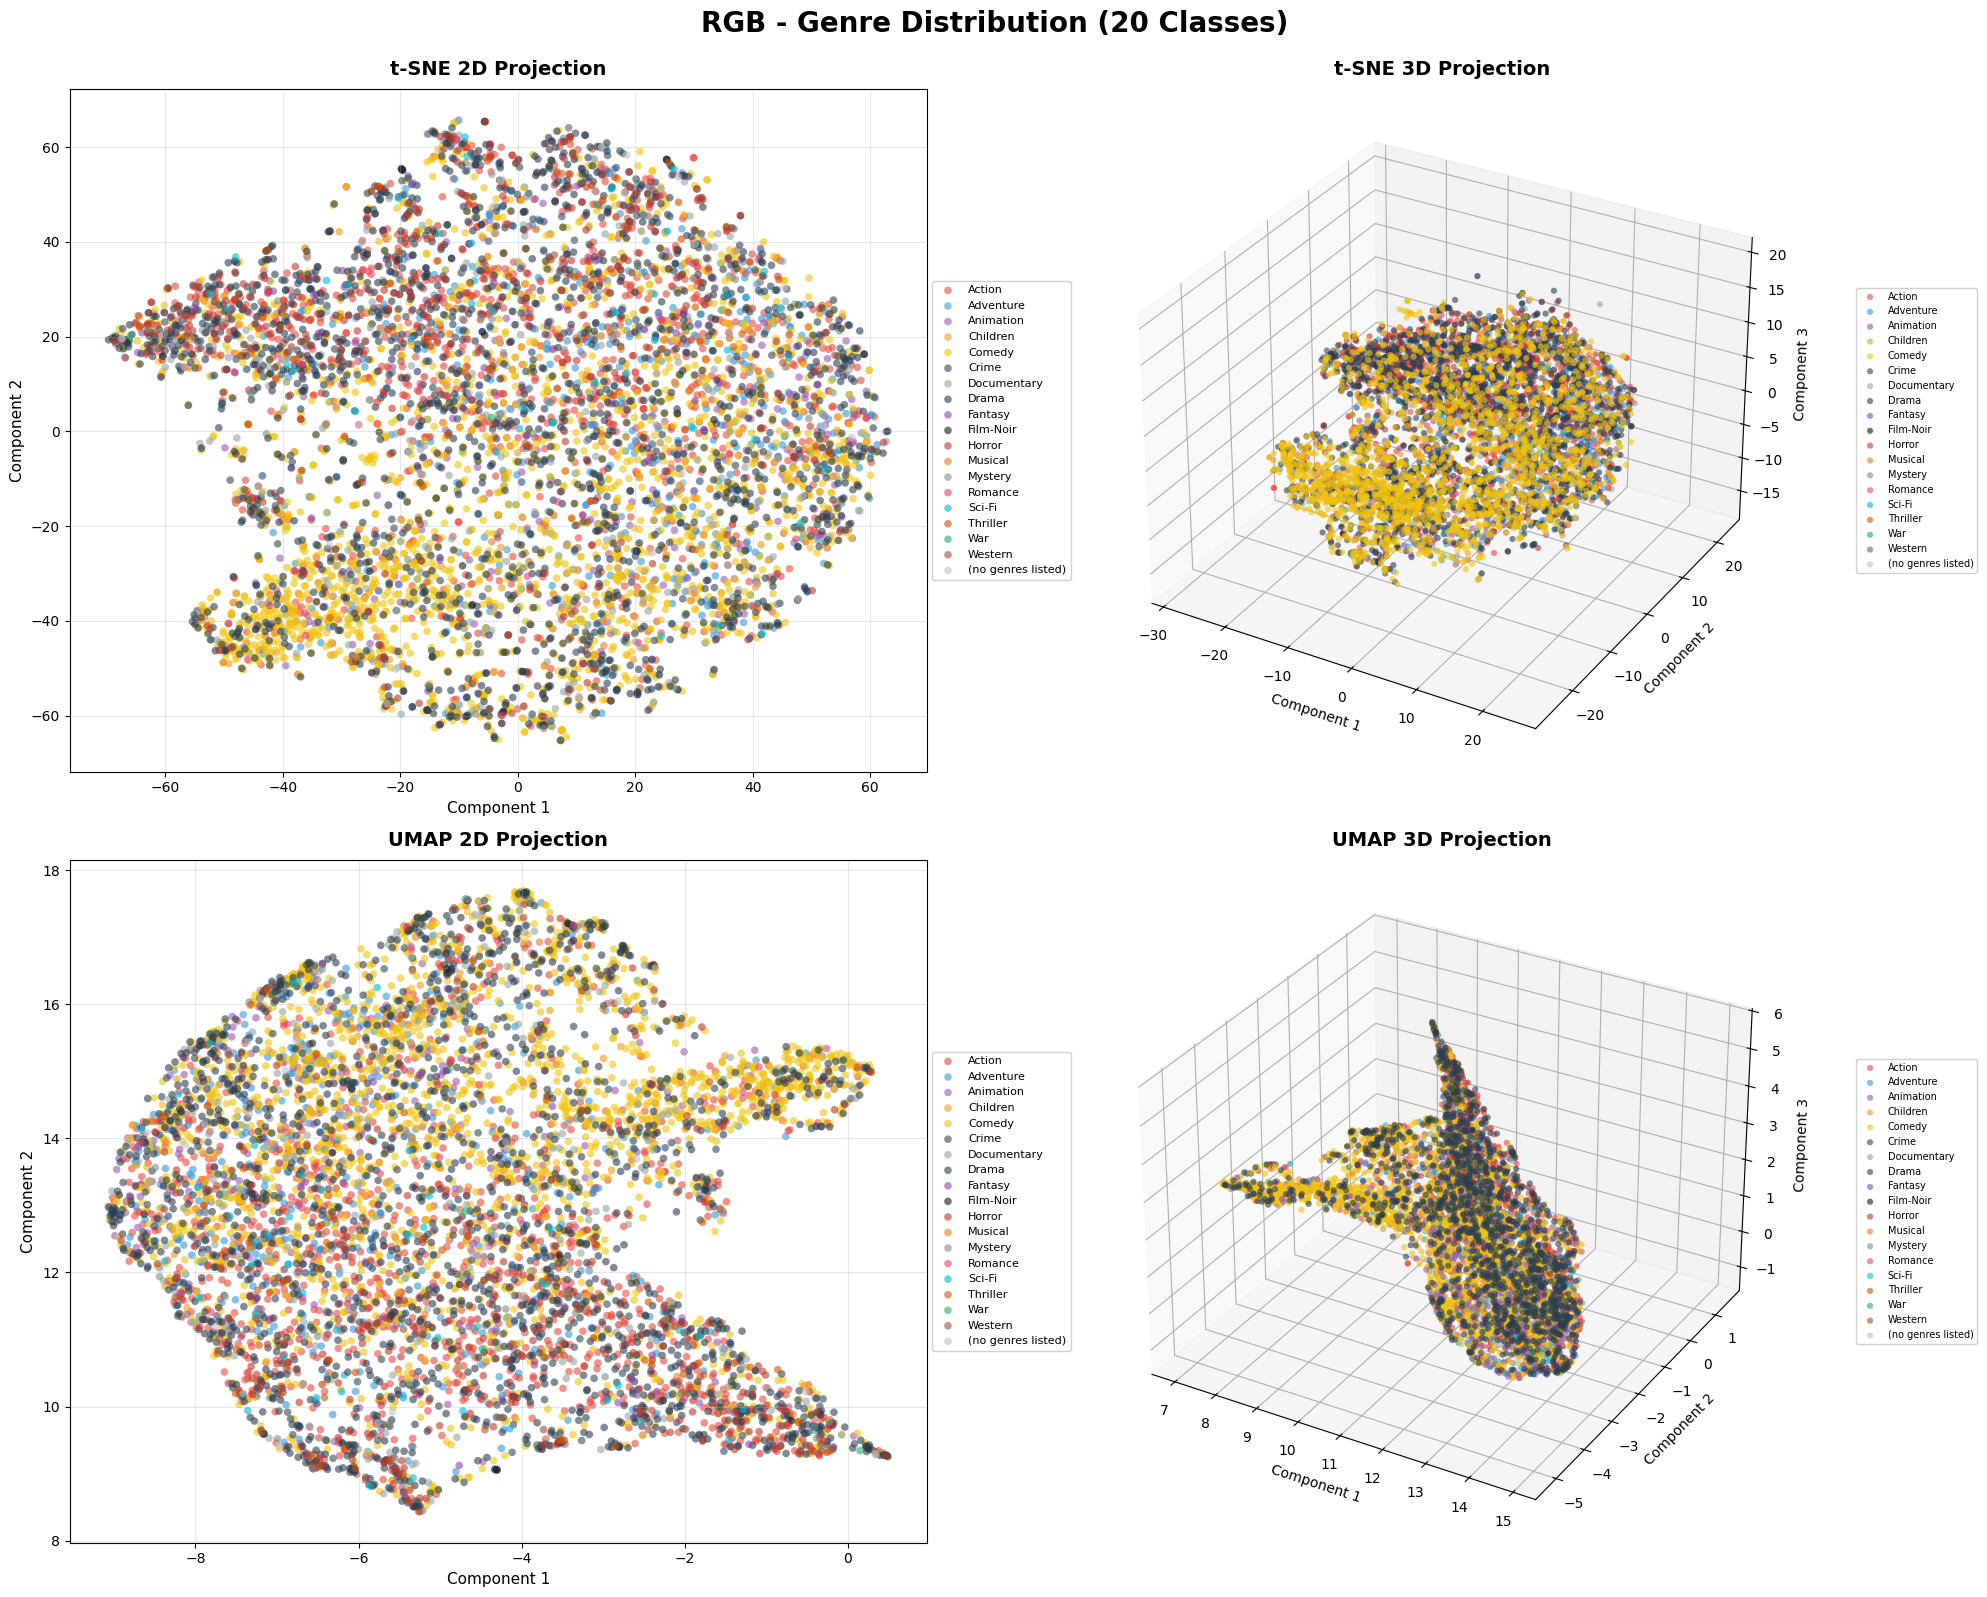

✓ Visualization complete!

Example 2: Visualize RGB, HSV, RGB_HSV
Visualizing 3 features...

[1/3]

Visualizing: RGB
✓ Found: t-SNE 2D, t-SNE 3D, UMAP 2D, UMAP 3D


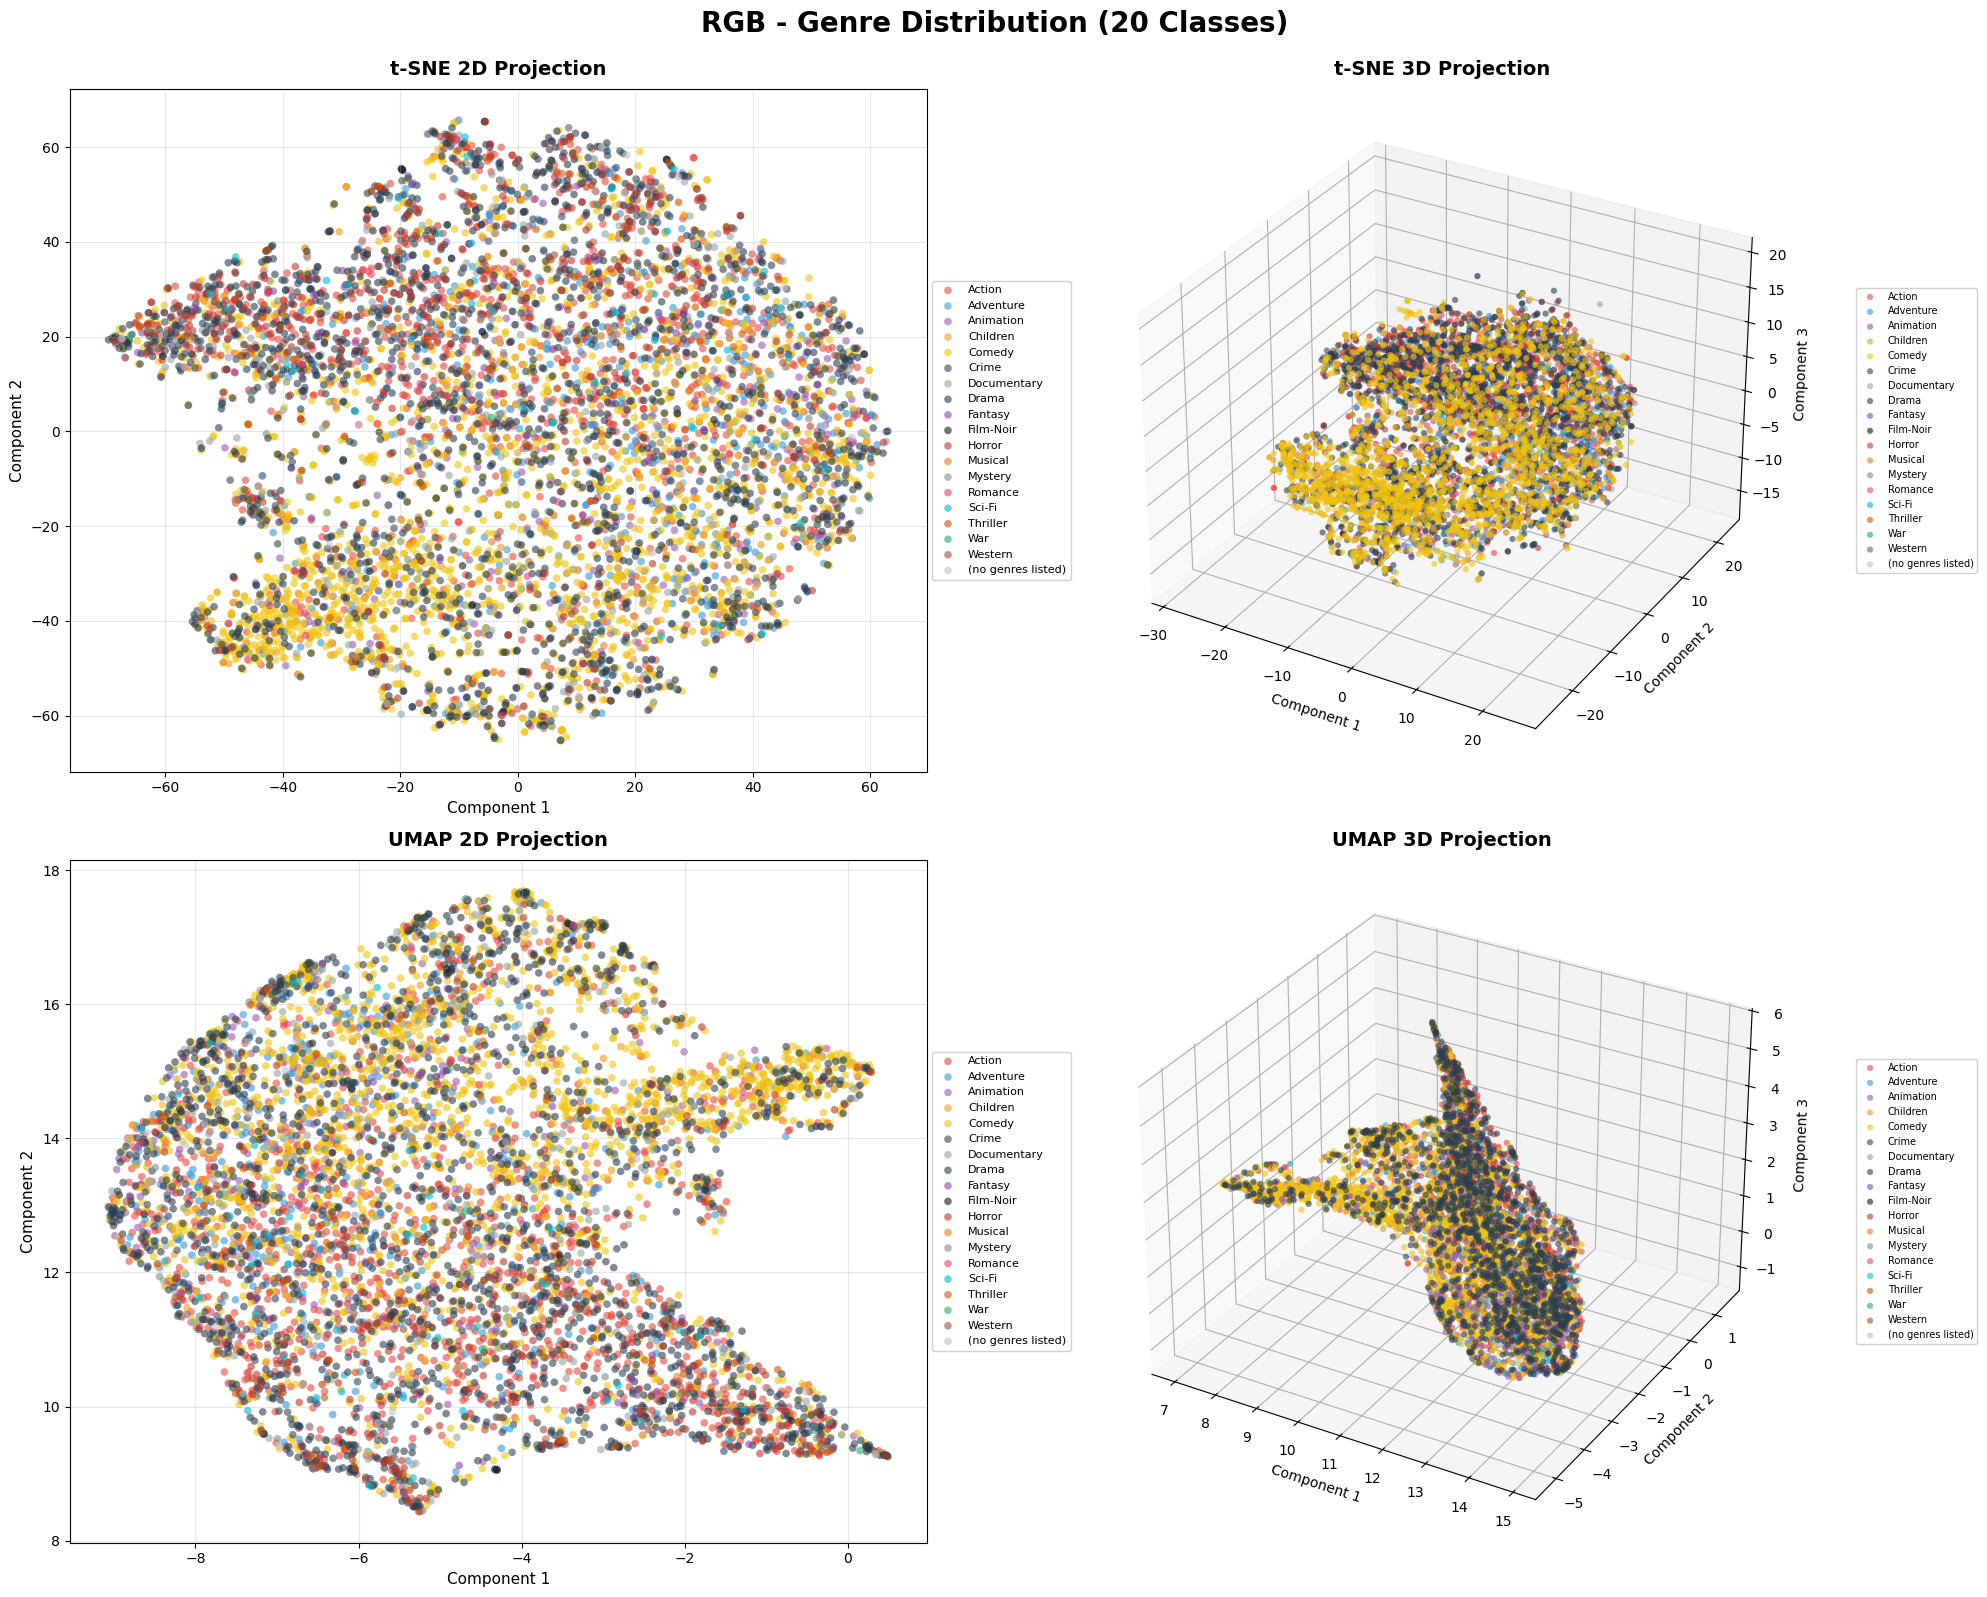

✓ Visualization complete!

[2/3]

Visualizing: HSV
✓ Found: t-SNE 2D, t-SNE 3D, UMAP 2D, UMAP 3D


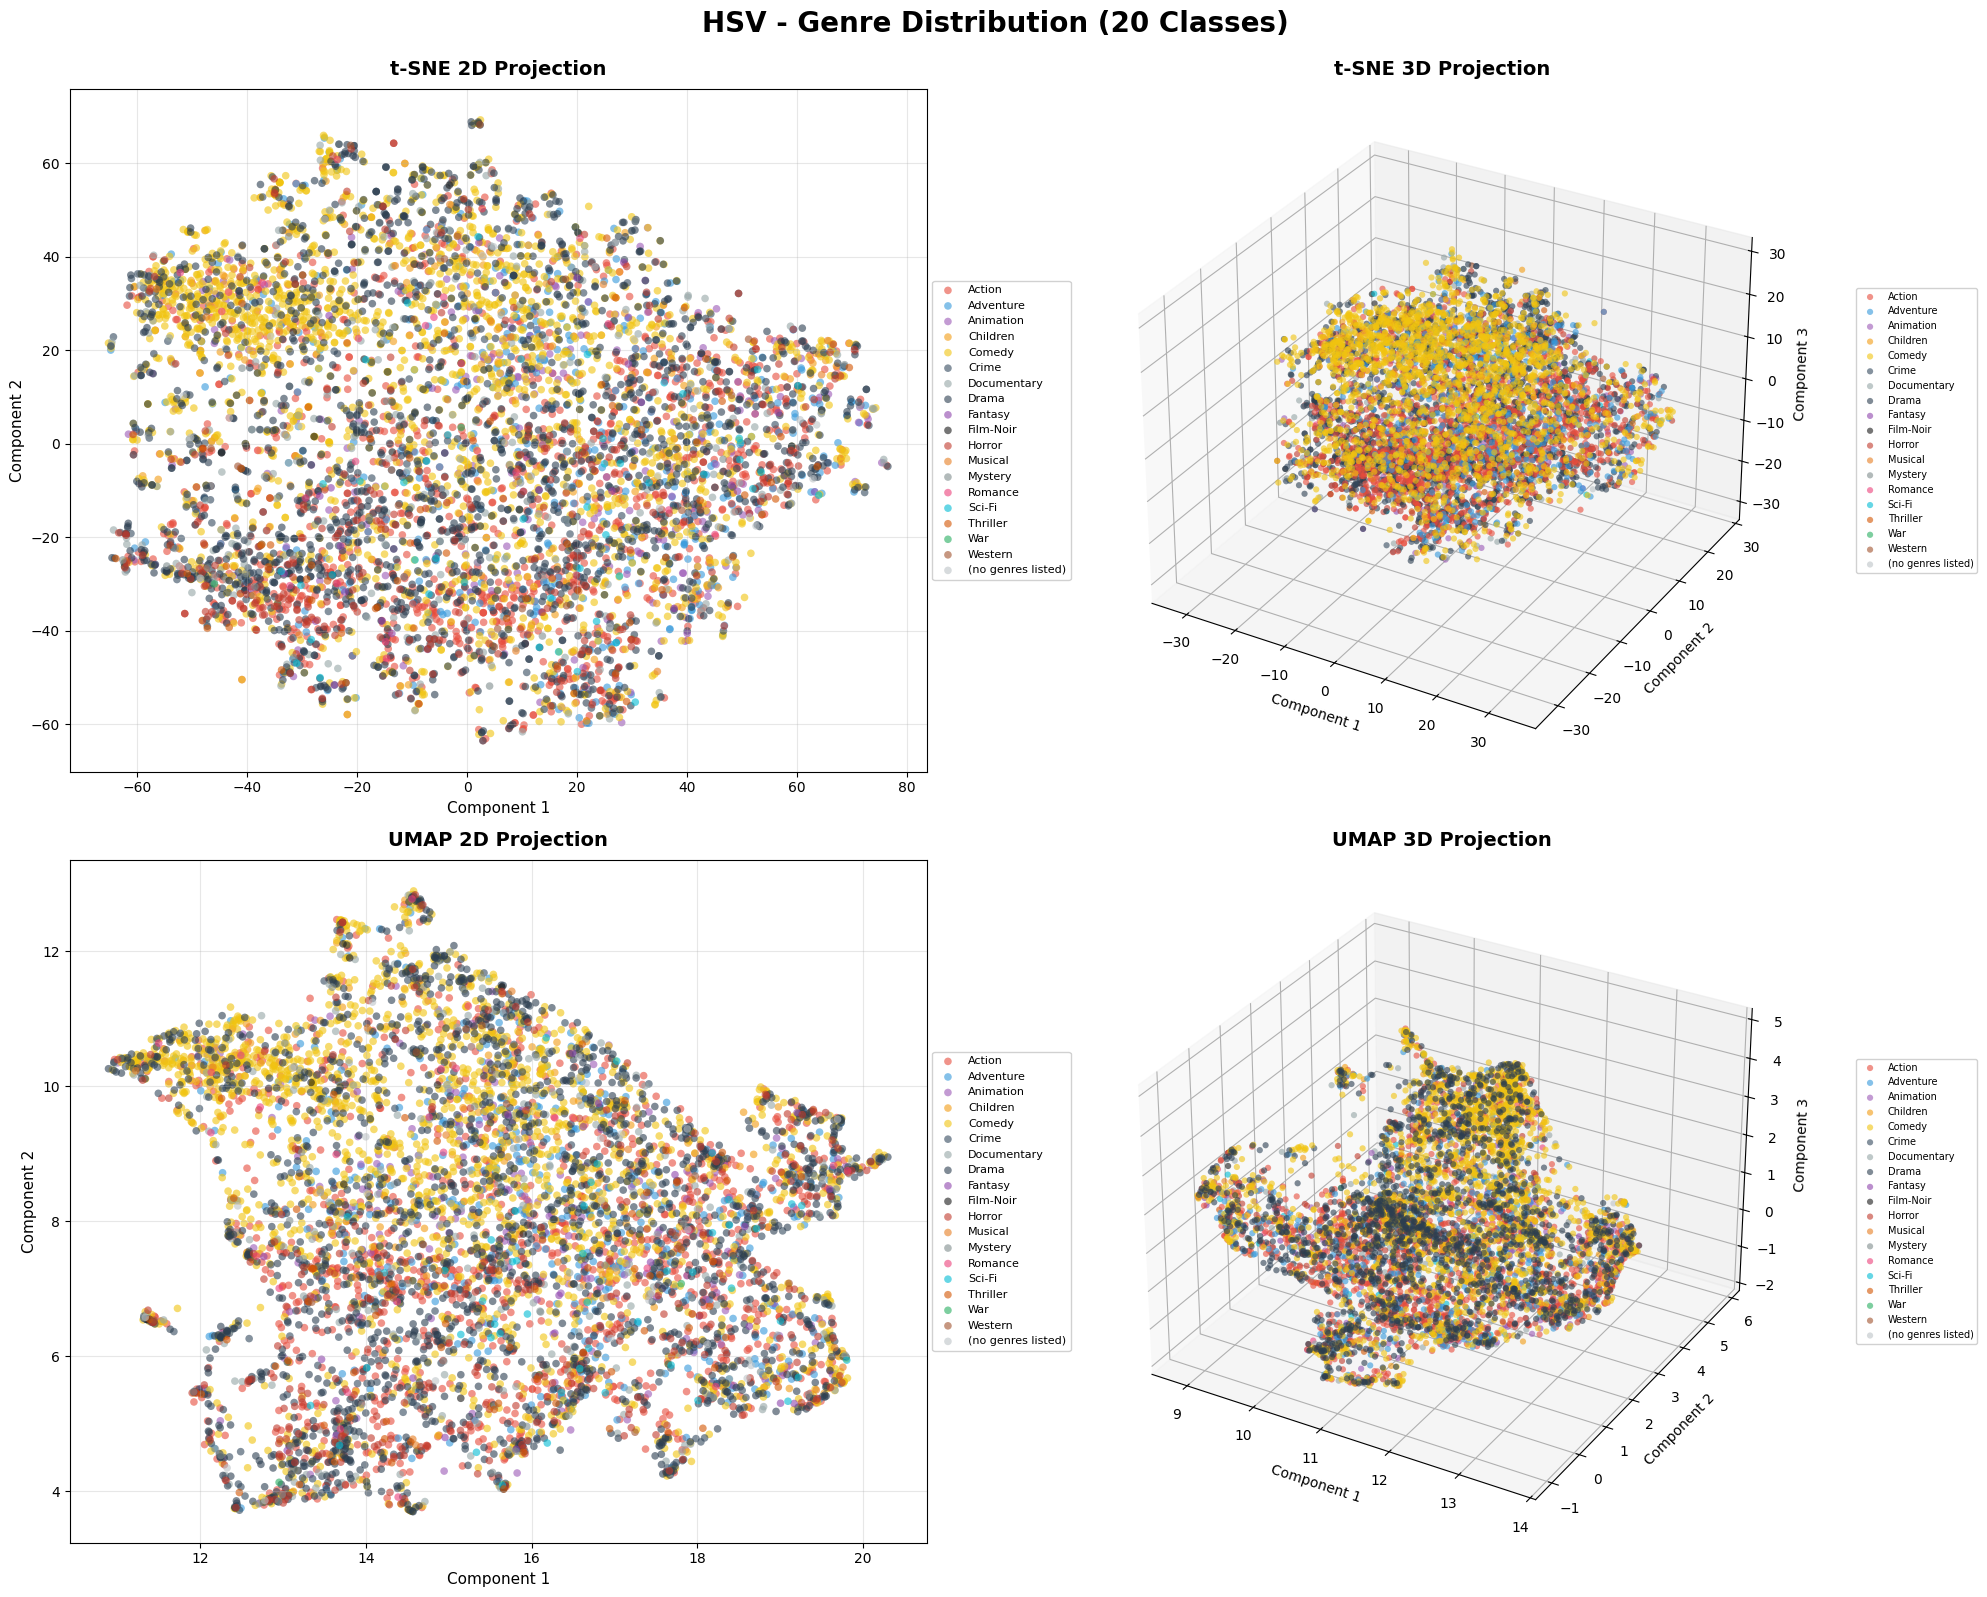

✓ Visualization complete!

[3/3]

Visualizing: RGB_HSV
✓ Found: t-SNE 2D, t-SNE 3D, UMAP 2D, UMAP 3D


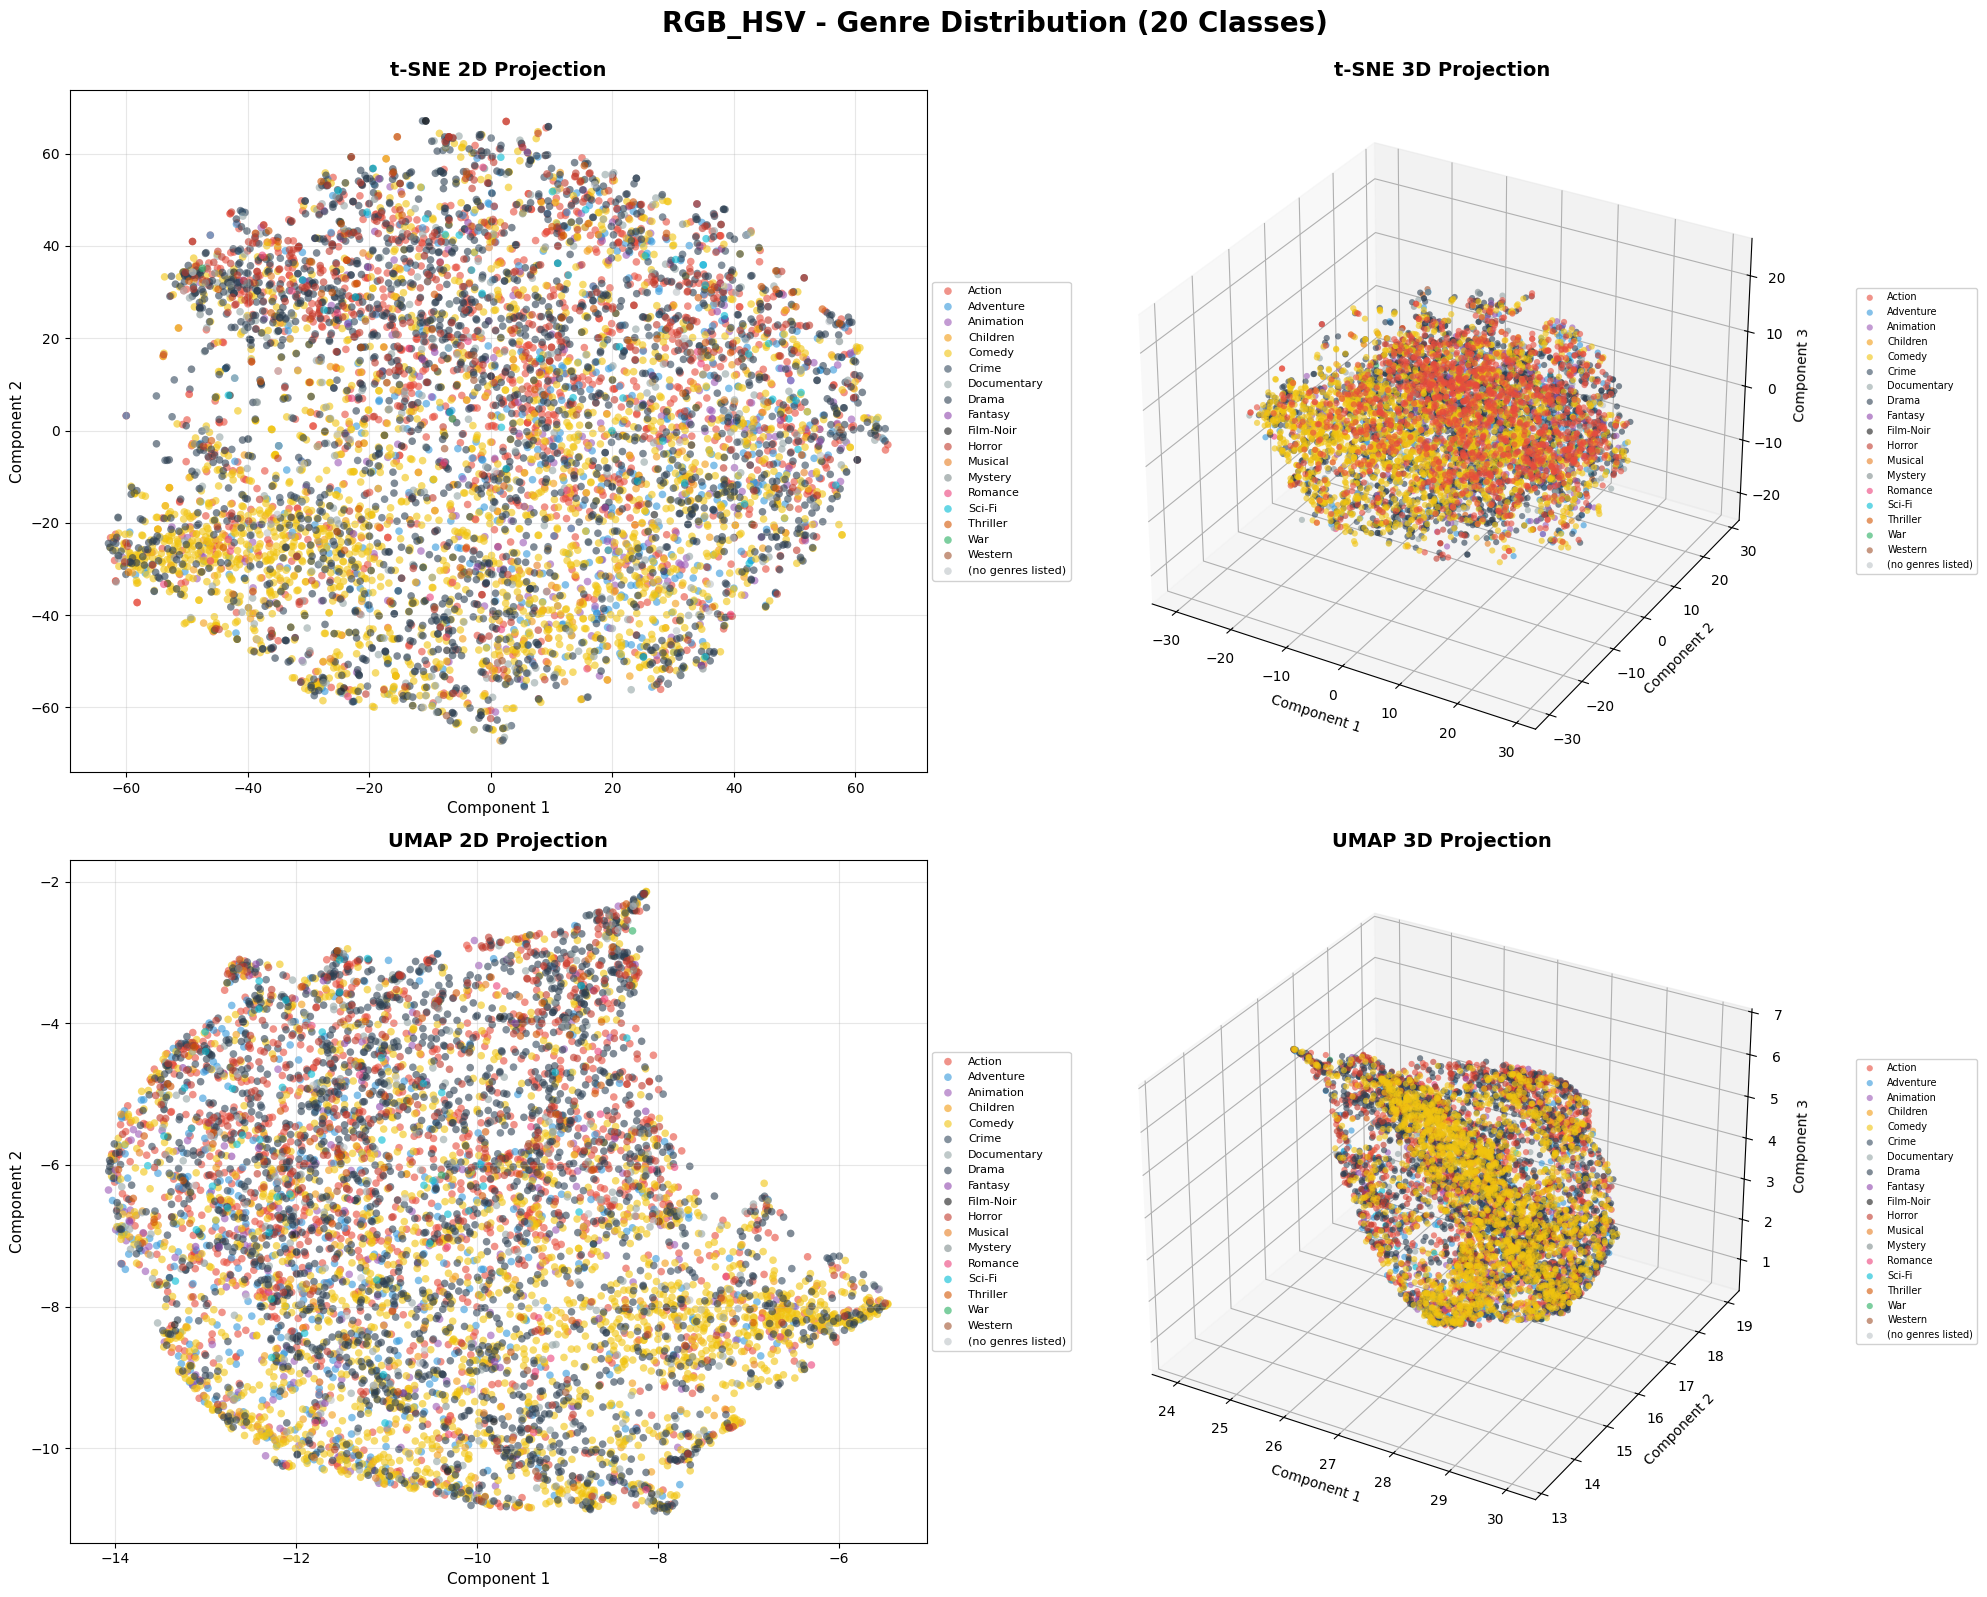

✓ Visualization complete!


In [6]:
# VISUALIZATION OF REDUCED FEATURES - FIXED VERSION
# Visualizes t-SNE and UMAP files that were created during dimensionality reduction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ========================================
# GENRE CONFIGURATION
# ========================================

GENRES = [
    'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
    'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
    'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)'
]

GENRE_COLORS = {
    'Action': '#e74c3c', 'Adventure': '#3498db', 'Animation': '#9b59b6',
    'Children': '#f39c12', 'Comedy': '#f1c40f', 'Crime': '#34495e',
    'Documentary': '#95a5a6', 'Drama': '#2c3e50', 'Fantasy': '#8e44ad',
    'Film-Noir': '#1a1a1a', 'Horror': '#c0392b', 'IMAX': '#16a085',
    'Musical': '#e67e22', 'Mystery': '#7f8c8d', 'Romance': '#ec407a',
    'Sci-Fi': '#00bcd4', 'Thriller': '#d35400', 'War': '#27ae60',
    'Western': '#a0522d', '(no genres listed)': '#bdc3c7'
}

# ========================================
# UTILITY FUNCTIONS
# ========================================

def load_genres(train_csv='movies_train.csv'):
    """Load primary genre for each movie"""
    df = pd.read_csv(train_csv)
    genre_dict = {}
    
    for _, row in df.iterrows():
        movie_id = row['movieId']
        genres = row['genres']
        
        if pd.isna(genres) or genres == '(no genres listed)':
            primary_genre = '(no genres listed)'
        else:
            primary_genre = genres.split('|')[0]
        
        genre_dict[movie_id] = primary_genre
    
    return genre_dict


def get_genre_colors_and_labels(movie_ids, genre_dict):
    """Get color array and labels for movies based on their genres"""
    colors = []
    labels = []
    
    for movie_id in movie_ids:
        genre = genre_dict.get(movie_id, '(no genres listed)')
        colors.append(GENRE_COLORS[genre])
        labels.append(genre)
    
    return np.array(colors), np.array(labels)


def find_feature_files(feature_name, feature_type):
    """
    Find the actual paths for a feature's t-SNE and UMAP files
    
    Args:
        feature_name: e.g., 'RGB', 'HSV', 'RGB_HSV'
        feature_type: e.g., 'pca_50d', 'svd_100d', 'lda_18d'
    
    Returns:
        Dictionary with paths to tsne_2d, tsne_3d, umap_2d, umap_3d files
    """
    
    paths = {
        'tsne_2d': None,
        'tsne_3d': None,
        'umap_2d': None,
        'umap_3d': None
    }
    
    # Determine base name and directory
    base_name = f"{feature_name}_{feature_type}"
    
    # Check if it's a single feature or combined
    single_features = ['RGB', 'HSV', 'GLCM', 'LBP', 'HOG', 'SIFT', 'Hu', 'Zernike']
    
    if feature_name in single_features:
        # Single feature path
        base_dir = Path('reduced_dim/single_features') / feature_name
    else:
        # Combined feature path
        base_dir = Path('reduced_dim/combined_features') / feature_name
    
    if not base_dir.exists():
        return paths
    
    # Look for t-SNE and UMAP files (NOT pca/lda/svd, only tsne/umap!)
    for suffix, key in [('tsne_2d', 'tsne_2d'), ('tsne_3d', 'tsne_3d'),
                        ('umap_2d', 'umap_2d'), ('umap_3d', 'umap_3d')]:
        file_path = base_dir / f"{feature_name}_{suffix}.csv"
        if file_path.exists():
            paths[key] = file_path
    
    return paths


# ========================================
# MAIN VISUALIZATION FUNCTION
# ========================================

def visualize_feature(feature_name, train_csv='movies_train.csv'):
    """
    Visualize t-SNE and UMAP projections for a feature
    
    Args:
        feature_name: Feature name (e.g., 'RGB', 'HSV', 'RGB_HSV')
        train_csv: Path to training CSV with genres
    
    Creates one figure with 4 subplots:
        - t-SNE 2D, t-SNE 3D, UMAP 2D, UMAP 3D
    """
    
    print(f"\n{'='*70}")
    print(f"Visualizing: {feature_name}")
    print(f"{'='*70}")
    
    # Load genres
    genre_dict = load_genres(train_csv)
    
    # Find files
    paths = find_feature_files(feature_name, 'pca_50d')  # dummy feature_type to get dir
    
    # Actually, let's search more carefully
    # Determine directory
    single_features = ['RGB', 'HSV', 'GLCM', 'LBP', 'HOG', 'SIFT', 'Hu', 'Zernike']
    
    if feature_name in single_features:
        feature_dir = Path('reduced_dim/single_features') / feature_name
    else:
        feature_dir = Path('reduced_dim/combined_features') / feature_name
    
    if not feature_dir.exists():
        print(f"❌ Directory not found: {feature_dir}")
        return
    
    # Find t-SNE and UMAP files
    tsne_2d = feature_dir / f"{feature_name}_tsne_2d.csv"
    tsne_3d = feature_dir / f"{feature_name}_tsne_3d.csv"
    umap_2d = feature_dir / f"{feature_name}_umap_2d.csv"
    umap_3d = feature_dir / f"{feature_name}_umap_3d.csv"
    
    # Check which files exist
    files_found = []
    if tsne_2d.exists(): files_found.append('t-SNE 2D')
    if tsne_3d.exists(): files_found.append('t-SNE 3D')
    if umap_2d.exists(): files_found.append('UMAP 2D')
    if umap_3d.exists(): files_found.append('UMAP 3D')
    
    if not files_found:
        print(f"❌ No t-SNE or UMAP files found in {feature_dir}")
        print(f"   Available files: {list(feature_dir.glob('*.csv'))[:5]}")
        return
    
    print(f"✓ Found: {', '.join(files_found)}")
    
    # Create figure
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle(f'{feature_name} - Genre Distribution (20 Classes)', 
                 fontsize=20, fontweight='bold', y=0.995)
    
    # Plot counter
    plot_idx = 1
    
    # ========================================
    # 1. t-SNE 2D
    # ========================================
    if tsne_2d.exists():
        ax1 = plt.subplot(2, 2, plot_idx)
        plot_idx += 1
        
        df = pd.read_csv(tsne_2d)
        movie_ids = df['movieId'].values
        X = df[['comp_0', 'comp_1']].values
        
        colors, labels = get_genre_colors_and_labels(movie_ids, genre_dict)
        
        # Plot each genre
        for genre in GENRES:
            mask = labels == genre
            if np.sum(mask) > 0:
                ax1.scatter(X[mask, 0], X[mask, 1], 
                           c=[GENRE_COLORS[genre]], 
                           label=genre, alpha=0.6, s=30, edgecolors='none')
        
        ax1.set_title('t-SNE 2D Projection', fontsize=14, fontweight='bold', pad=10)
        ax1.set_xlabel('Component 1', fontsize=11)
        ax1.set_ylabel('Component 2', fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8, 
                   framealpha=0.9, ncol=1)
    
    # ========================================
    # 2. t-SNE 3D
    # ========================================
    if tsne_3d.exists():
        ax2 = fig.add_subplot(2, 2, plot_idx, projection='3d')
        plot_idx += 1
        
        df = pd.read_csv(tsne_3d)
        movie_ids = df['movieId'].values
        X = df[['comp_0', 'comp_1', 'comp_2']].values
        
        colors, labels = get_genre_colors_and_labels(movie_ids, genre_dict)
        
        for genre in GENRES:
            mask = labels == genre
            if np.sum(mask) > 0:
                ax2.scatter(X[mask, 0], X[mask, 1], X[mask, 2],
                           c=[GENRE_COLORS[genre]], 
                           label=genre, alpha=0.6, s=20, edgecolors='none')
        
        ax2.set_title('t-SNE 3D Projection', fontsize=14, fontweight='bold', pad=10)
        ax2.set_xlabel('Component 1', fontsize=10)
        ax2.set_ylabel('Component 2', fontsize=10)
        ax2.set_zlabel('Component 3', fontsize=10)
        ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=7, 
                   framealpha=0.9, ncol=1)
    
    # ========================================
    # 3. UMAP 2D
    # ========================================
    if umap_2d.exists():
        ax3 = plt.subplot(2, 2, plot_idx)
        plot_idx += 1
        
        df = pd.read_csv(umap_2d)
        movie_ids = df['movieId'].values
        X = df[['comp_0', 'comp_1']].values
        
        colors, labels = get_genre_colors_and_labels(movie_ids, genre_dict)
        
        for genre in GENRES:
            mask = labels == genre
            if np.sum(mask) > 0:
                ax3.scatter(X[mask, 0], X[mask, 1], 
                           c=[GENRE_COLORS[genre]], 
                           label=genre, alpha=0.6, s=30, edgecolors='none')
        
        ax3.set_title('UMAP 2D Projection', fontsize=14, fontweight='bold', pad=10)
        ax3.set_xlabel('Component 1', fontsize=11)
        ax3.set_ylabel('Component 2', fontsize=11)
        ax3.grid(True, alpha=0.3)
        ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8, 
                   framealpha=0.9, ncol=1)
    
    # ========================================
    # 4. UMAP 3D
    # ========================================
    if umap_3d.exists():
        ax4 = fig.add_subplot(2, 2, plot_idx, projection='3d')
        plot_idx += 1
        
        df = pd.read_csv(umap_3d)
        movie_ids = df['movieId'].values
        X = df[['comp_0', 'comp_1', 'comp_2']].values
        
        colors, labels = get_genre_colors_and_labels(movie_ids, genre_dict)
        
        for genre in GENRES:
            mask = labels == genre
            if np.sum(mask) > 0:
                ax4.scatter(X[mask, 0], X[mask, 1], X[mask, 2],
                           c=[GENRE_COLORS[genre]], 
                           label=genre, alpha=0.6, s=20, edgecolors='none')
        
        ax4.set_title('UMAP 3D Projection', fontsize=14, fontweight='bold', pad=10)
        ax4.set_xlabel('Component 1', fontsize=10)
        ax4.set_ylabel('Component 2', fontsize=10)
        ax4.set_zlabel('Component 3', fontsize=10)
        ax4.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=7, 
                   framealpha=0.9, ncol=1)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Visualization complete!")


# ========================================
# BATCH FUNCTIONS
# ========================================

def visualize_all_single_features(train_csv='movies_train.csv'):
    """Visualize all single features"""
    
    single_features = ['RGB', 'HSV', 'GLCM', 'LBP', 'HOG', 'SIFT', 'Hu', 'Zernike']
    
    print("="*70)
    print("VISUALIZING ALL SINGLE FEATURES")
    print("="*70)
    
    for i, feature in enumerate(single_features, 1):
        print(f"\n[{i}/{len(single_features)}]")
        try:
            visualize_feature(feature, train_csv)
        except Exception as e:
            print(f"❌ Error: {e}")
            import traceback
            traceback.print_exc()


def visualize_all_combined_features(train_csv='movies_train.csv'):
    """Visualize all combined features"""
    
    combined_features = ['RGB_HSV', 'RGB_HSV_HOG', 'RGB_HSV_LBP', 
                        'RGB_HSV_GLCM', 'RGB_HSV_HOG_LBP', 'ALL']
    
    print("="*70)
    print("VISUALIZING ALL COMBINED FEATURES")
    print("="*70)
    
    for i, feature in enumerate(combined_features, 1):
        print(f"\n[{i}/{len(combined_features)}]")
        try:
            visualize_feature(feature, train_csv)
        except Exception as e:
            print(f"❌ Error: {e}")
            import traceback
            traceback.print_exc()


def visualize_specific_features(feature_list, train_csv='movies_train.csv'):
    """
    Visualize specific features
    
    Example:
        visualize_specific_features(['RGB', 'HSV', 'RGB_HSV'])
    """
    
    print(f"Visualizing {len(feature_list)} features...")
    
    for i, feature in enumerate(feature_list, 1):
        print(f"\n[{i}/{len(feature_list)}]")
        try:
            visualize_feature(feature, train_csv)
        except Exception as e:
            print(f"❌ Error: {e}")


# ========================================
# USAGE
# ========================================

if __name__ == "__main__":
    
    # Example 1: Single feature
    print("Example 1: Visualize RGB")
    visualize_feature('RGB')
    
    # Example 2: Multiple specific features
    print("\n" + "="*70)
    print("Example 2: Visualize RGB, HSV, RGB_HSV")
    visualize_specific_features(['RGB', 'HSV', 'RGB_HSV'])
    
    # Example 3: All single features
    # visualize_all_single_features()
    
    # Example 4: All combined features
    # visualize_all_combined_features()